# Overview

Well, this project aims to do what is says on the tin. Take the XCT data on pores, and evaluate it to determine the amount of clusters that are present, which will then be fed into the Gaussian Mixture Model in a seperate project. 

We're first going to create an elbow plot, maybe a dendrogram. If these don't work, we'll chance a Silhouette Score, and god forbid we have to try the preferred method, the Bayesian Information Criterion. So much to do, so little time...

# Importing Libraries

In [10]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# Importing Data

In [7]:
Allpores_XCT = pd.read_csv('All_Pores_XCT.csv', index_col = 0)
#We established that only 5 columns were relevant to us, there's a lot of irrelevant features here. We're gonna drop most of them here 
Allpores_XCT = Allpores_XCT[['Diameter [mm]', 'Voxel', 'Surface [mm²]', 'Compactness', 'Sphericity', 'Projected size z [mm]', 'AspectRatio','GasFlow']]
Allpores_XCT.shape

(102800, 8)

In [8]:
Allpores_XCT.sample(5)

,Diameter [mm],Voxel,Surface [mm²],Compactness,Sphericity,Projected size z [mm],AspectRatio,GasFlow
3680,0.15,104,0.03,0.10,0.52,0.13,1.000000,low
5621,0.12,60,0.02,0.13,0.61,0.05,1.500000,low
81319,0.64,1977,0.47,0.03,0.25,0.44,1.300000,low
88032,0.34,714,0.18,0.07,0.33,0.19,1.133333,low
24658,0.13,98,0.03,0.15,0.51,0.10,0.692308,low


# Dendrogram Method

Spoiler Alert, we only care about the BIC score here, but we're still gonna work our way through these other methods, as they could provide some useful information. The also make for pretty graphs. First on the chopping block, the Dendrogram. 

At the beginning, each data point is considered a single cluster, represented as a leaf node in the dendrogram. The dendrogram starts by calculating the distance or dissimilarity between each pair of data points, typically using a chosen distance metric such as Euclidean distance. Based on these pairwise distances, the algorithm iteratively merges the closest clusters into larger clusters, gradually forming a hierarchical structure. The process continues until all data points are fused into a single cluster, forming the root node of the dendrogram. The height or vertical position of each fusion (branch) in the dendrogram corresponds to the distance or dissimilarity at which the clusters were merged. Shorter branches indicate close similarity between clusters, while longer branches suggest greater dissimilarity. The horizontal axis of the dendrogram represents the individual data points or clusters, arranged in the order they were merged. Dendrograms are useful for visualizing the clustering process and identifying natural groupings or clusters within the data. By examining the dendrogram, analysts can determine the optimal number of clusters to use for their specific application, based on the desired level of granularity or separation.

For the below method, we'll first show what a healthy dendrogram looks like on a test set. Then for our dataset, its 102,000 samples long. That's ginourmous. We should really be calculating one dendrogram for the lot of it but my poor old old laptop can't hack it however. I'm gonna sample (1%) of it, and try it that way. I tried 10% but that took forever and a day and didn't even work.


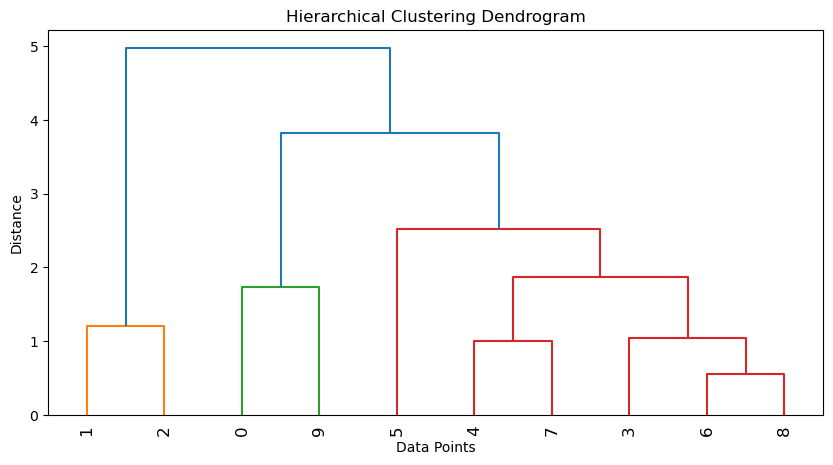

In [12]:
# Create a sample numerical dataframe
data = {
    'A': np.random.randn(10),
    'B': np.random.randn(10),
    'C': np.random.randn(10)
}
df = pd.DataFrame(data)

# Perform hierarchical clustering
Z = linkage(df, method='ward')  # Using Ward's method for linkage

# Plot the dendrogram
plt.figure(figsize=(10, 5))
dendrogram(Z, labels=df.index, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()


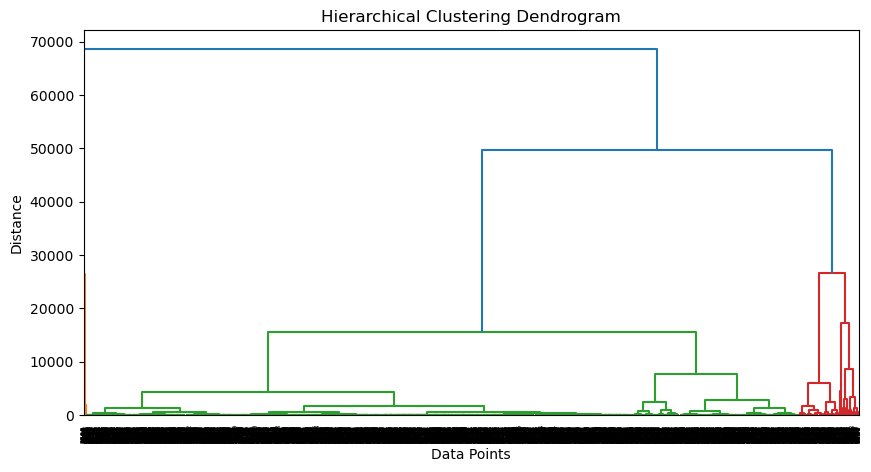

In [13]:
#Removing the categorical feature
df_dendrogram = Allpores_XCT.iloc[:,:-1]
df_dendrogram = df_dendrogram.sample(int(len(df_dendrogram)/20))

# Perform hierarchical clustering
Z = linkage(df_dendrogram, method='ward')  # Using Ward's method for linkage

# Plot the dendrogram
plt.figure(figsize=(10, 5))
dendrogram(Z,  leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

This graph doesn't tell us much really does it. Thing is with dendrograms, they can be subjective at times. The largest vertical distance is fairly blatant here, but drawing a horizontal line accross it could intercept the graph at anything from 2 to 4 clusters. 

Time to move onto elbow plots. 

# Elbow Plot

An elbow plot displays the relationship between the number of clusters and a chosen clustering metric, typically the within-cluster sum of squares (WCSS) or the average silhouette score. The plot shows the value of the clustering metric for different numbers of clusters, ranging from a small number to a maximum specified by the user. As the number of clusters increases, the clustering metric generally decreases, reflecting the decrease in within-cluster variation as more clusters are added. The "elbow point" on the plot represents a point of inflection, where the rate of decrease in the clustering metric slows down significantly. The optimal number of clusters is often chosen at the elbow point, as it indicates the point at which additional clusters do not significantly improve the clustering quality. However, identifying the elbow point can be subjective and may require visual inspection of the plot.

This is again a subjective method. Sometimes there is an elbow, sometimes there is not. C'est la vie. Sowieso. Sin e an tsaol

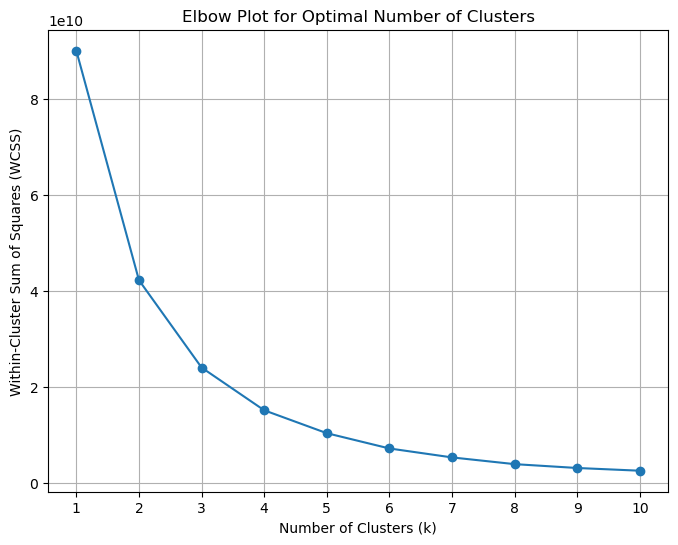

In [14]:
from sklearn.cluster import KMeans

#Removing the categorical feature
df_elbow = Allpores_XCT.iloc[:,:-1]

# Calculate WCSS for different values of k (number of clusters)
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_elbow)
    wcss.append(kmeans.inertia_)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-')
plt.title('Elbow Plot for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()


This was actually a good bit better than I had expected! After k=2 we see a slower decline, however again, this is subjective. We don't like subjective here, we want objective. 

Now we're gonna try Silhouette Scores.

# Silhouette Scores

Silhouette scores is a clustering evaluation metric used to calculate how well a clustering technique grouped datapoints. Its values range from [-1,1]. A value of 1 indicates that clusters are well apart from each other, and clearly distinguished. A value of 0 means that clusters are indifferent to each other, while a score of -1 indicates clusters are incorrectly assigned.

The silhouette score for a datapoint ‘i’ is calculated from the following equation:

\begin{align}
s_{i} = \frac{b_{i} - a_{i}}{max(b_{i},a_{i})}
\end{align}

Where $b_{i}$ is the inter cluster distance, and $a_{i}$ is the intra cluster distance. The inter cluster difference is the average distance to the closest cluster to datapoint ‘i’, that it is not part of. Mathematically this is given below:
\begin{align}
b_{i} = min_{i \neq k } \frac{1}{|C_{k}|}\sum_{j \in C_{k}} d(i,j)
\end{align}

Where $C_{k}$ is the closest cluster to ‘i’. The intra cluster distance is defined as the average distance between datapoint i and other datapoints within the cluster it is a part of. Mathematically this is given below: 

\begin{align}
a_{i} = \frac{1}{|C_{i} - 1|}\sum_{j \in C_{k}, i \neq j}d(i,j)
\end{align}

The Silhouette Score for a dataset is then calculated as the average silhouette score of the dataset.

Silhouette score for 2 clusters: 0.9439
Silhouette score for 3 clusters: 0.8773
Silhouette score for 4 clusters: 0.8456
Silhouette score for 5 clusters: 0.7826
Silhouette score for 6 clusters: 0.7587
Silhouette score for 7 clusters: 0.7176
Silhouette score for 8 clusters: 0.7016
Silhouette score for 9 clusters: 0.6958
Silhouette score for 10 clusters: 0.6744


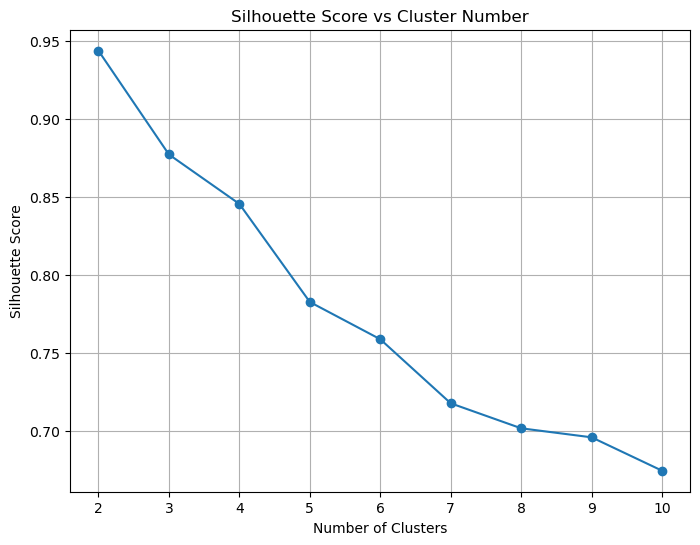

In [15]:
from sklearn.metrics import silhouette_score

#Removing the categorical feature
df_silhouette = Allpores_XCT.iloc[:,:-1]
df_silhouette = df_silhouette.sample(int(len(df_silhouette)/10))

silhouette_scores = []

# Iterate over different numbers of clusters (k)
for k in range(2, 11):
    # Initialize and fit KMeans clustering model
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_silhouette)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(df_silhouette, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Print silhouette scores for each number of clusters
for k, score in enumerate(silhouette_scores, start=2):
    print(f"Silhouette score for {k} clusters: {score:.4f}")

# Plot silhouette score versus cluster number
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-')
plt.title('Silhouette Score vs Cluster Number')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()

OK well this seems to indicate 2 clusters is best, as it gives us the highest silhouette score of 0.9. We sampled 10% of the dataset here, as it was taking a bit long with the whole dataset. 

Now finally, lets get to the BIC score. This is the only one we care about really, as this is what's generally used to evaluate cluster numbers for Gaussian Mixture Models.

# BIC Scores


Bayesian Information Criterion (BIC) scores are used to find the optimal number of clusters for Gaussian Mixture Models (GMMs) by balancing model complexity with goodness of fit.

BIC penalizes overly complex models to prevent overfitting while favoring models that accurately represent the data.

By minimizing the BIC score, we can automatically select the number of clusters that strike a balance between simplicity and accuracy.

BIC provides a principled and widely accepted criterion for model selection without requiring manual inspection or subjective judgment.

Overall, BIC scores offer a robust approach for determining the appropriate number of clusters in GMMs across different datasets and modeling scenarios.

C:\Users\conor\anaconda3\Lib\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


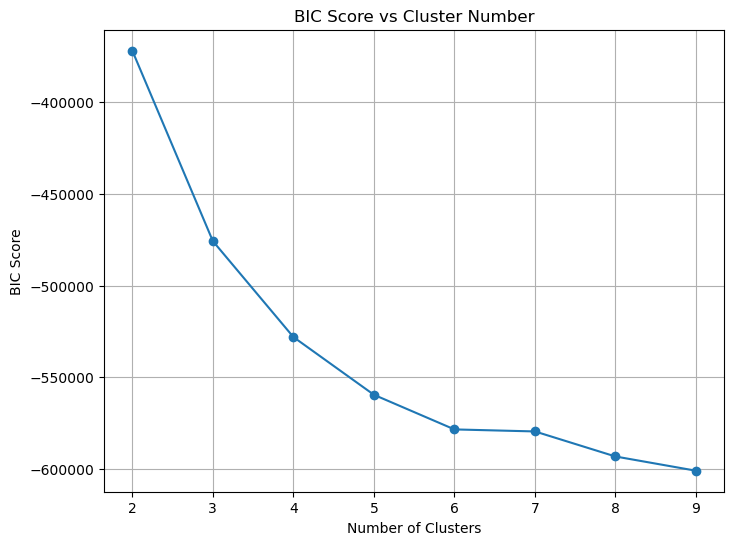

In [16]:
from sklearn.mixture import GaussianMixture
from sklearn import metrics

#Removing the categorical feature
df_bic = Allpores_XCT.iloc[:,:-1]
df_bic = df_bic.sample(int(len(df_bic)/2))

# Initialize BIC scores list
bic_scores = []

# Iterate over different numbers of clusters (k)
for k in range(2, 10):
    # Initialize Gaussian Mixture Model with k clusters
    gmm = GaussianMixture(n_components=k, random_state=42)
    
    # Fit the model to the data
    gmm.fit(df_bic)
    
    # Calculate BIC score
    bic_score = gmm.bic(df_bic)
    
    # Append BIC score to the list
    bic_scores.append(bic_score)

# Plot BIC scores versus cluster number
plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), bic_scores, marker='o', linestyle='-')
plt.title('BIC Score vs Cluster Number')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC Score')
plt.xticks(range(2, 10))
plt.grid(True)
plt.show()

This is a bit annoying. We can't see any clear minimum in BIC score here. The graph does seem to be converging to a value however. We could also place a condition on the graph where we stop iterating if the BIC score doesn't decrease by any more than some minimum value. 

Based on the Silhouette Scores we have though, 2 seems to be the optimal cluster number. We'll proceed with that value for our analysis. 